В этом блоке мы познакомимся с практическим применением гауссовских процессов на примере прогнозирования финансового ряда. Сначала построим нелинейный тренд. А потом по аналогии, в качестве задания предлагается добавить сезонную компоненту.

Для оценки регрессии на гауссовских процессах существуют специализированные пакеты, одни из самых популярных - GPy на языке Python, GPML на Matlab, GPFlow на TensorFLow.
Но для лучшего понимания математики, в учебных целях, - мы построим прогноз на вероятностном языке моделирования stan, где пропишем регрессию в виде формул. Stan - высокопроизводительный фреймворк для байесовских моделей и не только. На нем удобно сформулировать модель в виде уравнений, и далее программа методом точечной оптимизации, MCMC, или Variational Inference  оценивает параметры с высокой производительностью.  От конкурентов его отличает очень хорошая реализация алгоритма HMC (Hamilton Markov Chain). Подробнее о Stan - https://mc-stan.org/users/documentation/. 

In [14]:
import pystan #интерфейc stan в питоне
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
timeSeries = pd.read_csv('data.csv',sep = ';',decimal=',')["x"] # пример финансового временного ряда

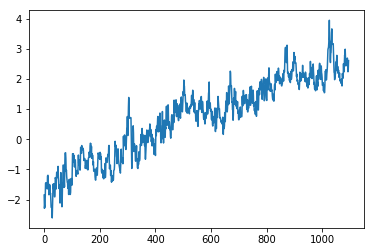

In [15]:
timeSeries.plot()

Давайте спрогнозируем данный временной ряд. Первые 730 точек (2 года) будут использоваться для обучения. А прогноз будем строить на последних 365 точек.


Создадим файл с кодом на языке stan. Подробно про язык Stan смотрите в приложении "stan-manual.pdf". 

In [33]:
%%writefile GaussianProcess.stan 

//определяется тип данных
data {
    int N1;        //число наблюдений в обучающей выборке
    real x1[N1];   //факторы - в нашем случае время
    vector[N1] y1; //наблюдаемые величины в обучающей выборке
    int N2;        //число наблюдений в тестовой выборке
    real x2[N2];   //факторы на тестовой выборке - в нашем случае время в будущем  
}

//генерируются данные внутри программы, или обрабатывается, то что определено в блоке data
transformed data{ 
    vector[N1] mu = rep_vector(.0, N1); //нулевой уровень, вокруг которого строится гауссовский процесс
}


//параметры модели, - в нашем случае гиперпараметры ядра
parameters {              //параметры ядра
    real<lower=0> a;      //амплитуда RBF ядра
    real<lower=0> l;      //эффективная длина RBF ядра
    real<lower=0> sigma;  //ошибка регрессии
    
}

//параметры могут обрабатываться
transformed parameters{
    matrix[N1,N1] K; //матрица ковариации для обучающей выборки
    
    for (i in 2:N1)
        for(j in 1:(i-1))
        {
            K[i,j] = square(a) * exp(-square(x1[i]-x1[j])*inv_square(l*365)*0.5 );
            K[j,i] = K[i,j]; // делаем ее симметричной
        }
    
    for (n in 1:N1)
        K[n,n] = square(a) +
                 square(sigma) +   
                 1e-12;    // слагаемое для того, чтобы матрица всегда оставалась положительно определенной на этапе оптимизации
}

// В этом блоке связываются параметры и данные через распределения. Stan авто-
// матически строит функции правдоподобия и оптимизирует параметры распределения. 
// Дополнительно, можно добавлять приорные распределения для параметров модели
model { 
    
    
    y1 ~ multi_normal(rep_vector(0,N1),K); 
    
    
    a ~ normal(0, 1);  //приорное распределение магнитуды колебания ряда
    l ~ lognormal(2, .1); // приорное распределение эф. длины
                          // нас интересует глобальный тренд, поэтому мы определили распределение подальше от нуля. 
                          // приорные распределения выставляются на "глаз", чтобы подсказать оптимизатору какого порядка должны быть параметры
    
}

//В блоке генерируются значения на основе оцененных параметров

generated quantities{
matrix[N2,N1] Kstar; //матрица ковариации между факторами прогнозными и факторами обучающими
vector[N2] yforecasted; //прогноз
    for (i in 1:N2)
        for(j in 1:N1)
            Kstar[i,j] = square(a) * exp(-square(x2[i]-x1[j]) * inv_square(l*365) * 0.5);
    
yforecasted = Kstar * (K\y1); //предскажем прогнозное среднее    
}



Overwriting GaussianProcess.stan


Код модели в Stan компилируется в машинный код

In [34]:
CompiledModel =  pystan.StanModel(file='GaussianProcess.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d930d6b522172fde93784e5e8a51a677 NOW.


Для обучения будем использовать 730 (2 года) наблюдений. Построим долгосрочный тренд 

In [35]:
totalNumberOfObs = len(timeSeries)
numberForLearning = 730 #два года 

inputDataForStan = {
    'N1' : numberForLearning,
    'x1' : range(0,numberForLearning),
    'y1' : timeSeries[0:numberForLearning],
    'N2' : totalNumberOfObs, #прогноз будет по
    'x2' : range(0,totalNumberOfObs)
}

Получим значения оптимальных параметров, согласно спецификации модели определенной в stan

In [36]:
optimized = CompiledModel.optimizing(data = inputDataForStan)
yforecasted = optimized["yforecasted"]

Слева от вертикальной линии - обучающая выборка. Справа будущее. 

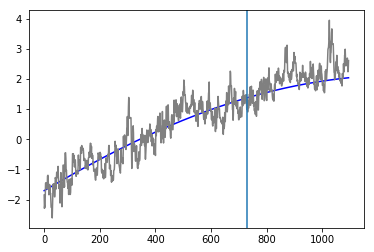

In [37]:
plt.plot(yforecasted,'blue' ) 
plt.plot(timeSeries, 'grey')
plt.axvline(x=730)

Задание:
Добавьте в файле stan слагаемое к ядру, отвечающее за сезонность.  
Используйте периодическое ядро с периодом 365 дней (год). Поиграйтесь с
параметром эффективной длины в периодическом ядре: чем меньше параметр, -  тем лучше
улавливается помесячная сезонность. 

В языке stan число пи - pi()

Stan manual - https://github.com/stan-dev/stan/releases/download/v2.17.1/stan-reference-2.17.1.pdf
    
    
    
    

Снова скомпилируйте файл - и постройте бэктест.
        
По поводу формы периодического ядра смотрите лекцию, или: 

https://www.cs.toronto.edu/~duvenaud/cookbook/
    
http://www.gaussianprocess.org/gpml/chapters/RW.pdf    


    

In [44]:
%%writefile GaussianProcessSeason.stan 

//определяется тип данных
data {
    int N1;        //число наблюдений в обучающей выборке
    real x1[N1];   //факторы - в нашем случае время
    vector[N1] y1; //наблюдаемые величины в обучающей выборке
    int N2;        //число наблюдений в тестовой выборке
    real x2[N2];   //факторы на тестовой выборке - в нашем случае время в будущем  
}

//генерируются данные внутри программы, или обрабатывается, то что определено в блоке data
transformed data{ 
    vector[N1] mu = rep_vector(.0, N1); //нулевой уровень, вокруг которого строится гауссовский процесс
}


//параметры модели, - в нашем случае гиперпараметры ядра
parameters {              //параметры ядра
    real<lower=0> a;      //амплитуда RBF ядра
    real<lower=0> l;      //эффективная длина RBF ядра
    real<lower=0> sigma;  //ошибка регрессии
    real<lower=0> b;      //амплитуда периодического ядра
    
}

//параметры могут обрабатываться
transformed parameters{
    matrix[N1,N1] K; //матрица ковариации для обучающей выборки
    
    for (i in 2:N1)
        for(j in 1:(i-1))
        {
            K[i,j] = square(a) * exp(-square(x1[i]-x1[j])*inv_square(l*365)*0.5 ) + 
            
            
//-------------------------Дописать cлагаемое--------------------------------------
            
           square(b) * exp(-square(sin(pi()*(x1[i]-x1[j])/365))*inv_square(30)*0.5);

//-----------------------------------------------------------------------
            
            
            K[j,i] = K[i,j];
        }
    
    for (n in 1:N1)
        K[n,n] = square(a) +
                 square(b) +   
                 square(sigma) +   
                 1e-12;    // слагаемое для того, чтобы матрица всегда оставалась положительно определенной на этапе оптимизации
}

// В этом блоке связываются параметры и данные через распределения. Stan авто-
// матически строит функции правдоподобия и оптимизирует параметры распределения. 
// Дополнительно, можно добавлять приорные распределения для параметров модели
model { 
    
      
    
    y1 ~ multi_normal(rep_vector(0,N1),K); 
    
    b ~ normal(0, 1);
    a ~ normal(0, 1);  //приорное распределение магнитуды колебания ряда
    l ~ lognormal(2, .1); // приорное распределение эф. длины
                          // нас интересует глобальный тренд, поэтому мы определили распределение подальше от нуля. 
                    
    
}

//в блоке генерируются значения на основе оцененных параметров

generated quantities{
matrix[N2,N1] Kstar; //матрица ковариации между факторами прогнозными и факторами обучающими
vector[N2] yforecasted; //прогноз
    for (i in 1:N2)
        for(j in 1:N1)
            Kstar[i,j] = square(a) * exp(-square(x2[i]-x1[j]) * inv_square(l*365) * 0.5)+
    
//-------------------------------аналогичное слагаемое здесь------------------
    
      square(b) * exp(-square(sin(pi()*(x2[i]-x1[j])/365))*inv_square(30)*0.5);
   
//-----------------------------------------------------------------------------
yforecasted = Kstar * (K\y1);    
}



Overwriting GaussianProcessSeason.stan


In [45]:
CompiledModel2 =  pystan.StanModel(file='GaussianProcessSeason.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_147833ecccdc511ac08df180bc84b86a NOW.


In [46]:
optimized = CompiledModel2.optimizing(data = inputDataForStan)
yforecasted = optimized["yforecasted"]

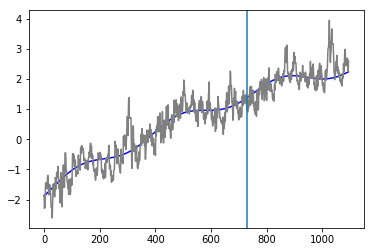

In [47]:
plt.plot(yforecasted,'blue' ) 
plt.plot(timeSeries, 'grey')
plt.axvline(x=730)

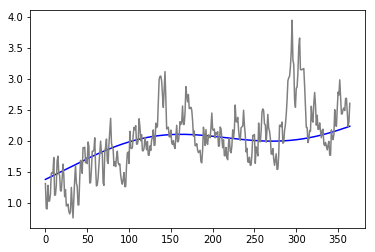

In [48]:
plt.plot(yforecasted[-365:],'blue' ) 
plt.plot(timeSeries[-365:].values,'grey')


Проверка на адекватность прогноза. Для "хорошего рисунка" пусть ошибка прогноза будет не выше 0.5.

In [49]:
np.sqrt(np.mean((yforecasted[-365:] - timeSeries[-365:])**2)) < 0.5


True